In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
import pandas as pd
#import scipy   
import tensorflow as tf
from tensorflow import keras
from matplotlib import ticker, cm
from time_double_string import time_double,time_string
from datetime import datetime
np.random.seed(46)

In [2]:
yr1=2013
yr2=2018
#dir0="C:/Users/Jimmy/OneDrive/Documents/work/lws/"
#dir0="/Users/ljx/OneDrive/Documents/work/lws/"
dir0="/home/ljx/work/lws/"
        
#Load Sym-H and AE index. Need to load the prior year data
for yr in range(yr1-1,yr2+1,1):
    if yr == yr1-1:
        df_symh = pd.read_csv(dir0+'lws_data/solarwind/symh_sme_'+str(yr)+'.csv')
    else:
        df_symh2= pd.read_csv(dir0+'lws_data/solarwind/symh_sme_'+str(yr)+'.csv')
        #df_symh = df_symh.append(df_symh2,ignore_index=True)       
        df_symh = pd.concat([df_symh,df_symh2],ignore_index=True)       

## Load probe orbit data and rbspice spinaveraged electron flux data
probes=['a','b']#,'b']
n_probes=len(probes)
for sc in probes:
    #Load the satellite coordinate data and rbspice data
    for yr in range(yr1,yr2+1,1):
        df2 = pd.read_csv(dir0+'lws_data/coord/includeLstar/coord_'+str(yr)+sc+'.csv')
        df3 = pd.read_csv(dir0+'lws_data/rbspice/rbspice'+sc+'_p_'+str(yr)+'.csv')
        if ((yr==yr1) & (sc == probes[0])):
            df_coord = df2
            df_flux  = df3
        else:
            df_coord=pd.concat([df_coord,df2],ignore_index=True) # Or: pd.concat([df1,df2,df3], ignore_index=True)
            df_flux =pd.concat([df_flux,df3],ignore_index=True)

#df_symh.drop(['SymD','SML','Density','Vx'], axis=1, inplace=True)
#df_coord=df_coord[['Datetime','Xsm','Ysm','Zsm','Lstar','L','MLT','LAT']]
# So that we can use the first 4 parameters that include Lstar

In [3]:
ind_symh_1= np.where(df_symh['Datetime']=='2017-09-09 00:02:30')[0][0]
ind_symh_2= np.where(df_symh['Datetime']=='2017-09-12 00:02:30')[0][0]
for i in range(ind_symh_1, ind_symh_2):
    if (~np.isfinite (df_symh['Pressure'][i])):
        df_symh.loc[i,'Pressure'] = df_symh.loc[i-1,'Pressure']
        df_symh.loc[i,'Density'] = df_symh.loc[i-1,'Density']
        df_symh.loc[i,'Vx'] = df_symh.loc[i-1,'Vx']
        df_symh.loc[i,'Bz'] = df_symh.loc[i-1,'Bz']

        #df_symh['Pressure'][i] = df_symh['Pressure'][i-1]
        #df_symh['Bz'][i] = df_symh['Bz'][i-1]
        #df_symh['Vx'][i] = df_symh['Vx'][i-1]
        #df_symh['Density'][i] = df_symh['Density'][i-1]
#df_symh=df_symh[["Datetime","SymH","AsyH","AsyD","SME","Pressure","Bz"]]


,Datetime,SymH,AsyH,SymD,AsyD,SME,SML,Density,Vx,Pressure,Bz
0,2012-01-01 00:02:30,-11.0,17.5,-1.5,28.5,189.0,-158.0,6.73,-367.90,1.83,1.88
1,2012-01-01 00:07:30,-9.5,17.0,-2.0,25.5,180.0,-145.0,6.73,-367.90,1.83,1.88
2,2012-01-01 00:12:30,-9.0,15.0,-2.0,26.0,166.0,-137.0,6.82,-369.30,1.88,1.80
3,2012-01-01 00:17:30,-8.0,14.0,-2.0,23.0,197.0,-143.0,7.12,-371.77,1.99,2.08
4,2012-01-01 00:22:30,-7.0,13.0,-2.5,21.0,177.0,-114.0,7.42,-374.23,2.10,1.80
...,...,...,...,...,...,...,...,...,...,...,...
736411,2018-12-31 23:37:30,-4.0,10.0,-1.0,6.5,53.0,-20.0,4.40,-472.50,1.96,3.29
736412,2018-12-31 23:42:30,-4.0,9.0,-1.0,7.0,56.0,-21.0,3.48,-471.95,1.56,3.30
736413,2018-12-31 23:47:30,-4.0,10.0,-1.0,6.0,52.0,-16.0,4.04,-468.35,1.77,3.07
736414,2018-12-31 23:52:30,-4.0,11.0,0.0,6.0,54.0,-18.0,4.48,-461.75,1.91,3.36


In [14]:
#Check Nan and Inf
datetime_arr=df_coord["Datetime"]
coord0 = df_coord.iloc[:,1:5]
#coord0=np.float32(df_coord.to_numpy()[:,1:5])
#symh_ae=np.float32(df_symh.to_numpy()[:,1:6]) #For this experiment, we only use SymH, AsyH, AsyD, SME and SML
symh_ae=df_symh.iloc[:,[1,2,4,5,8]]
#flux_data=np.float32(df_flux.to_numpy()[:,1:])
flux_data=df_flux.iloc[:,1:]
#symh_all=df_symh["SymH"].to_numpy().astype('float32')
#ae_all=df_symh["SME"].to_numpy().astype('float32')
ind_bad_flux=np.where(~np.isfinite(flux_data))

#Coord0: Xsm,Ysm,Zsm,L, MLT，LAT
#Coord1: L, cos(theta),sin(theta),Lat
#LL0 =np.float32(df_coord.to_numpy()[:,4])
#MLT0=np.float32(df_coord.to_numpy()[:,5])
#LAT0=np.float32(df_coord.to_numpy()[:,6])
#cost0=np.cos(MLT0*np.pi/12.0)
#sint0=np.sin(MLT0*np.pi/12.0)
#coord1=np.array([LL0,cost0,sint0,LAT0])
#coord1=coord1.transpose()


## Create tsec_arr
N_symh,M_symh=symh_ae.shape
ind1_symh=np.where(df_symh["Datetime"] == df_coord["Datetime"][0])
ind1_symh=ind1_symh[0][0]
#print(df_symh.iloc[ind1_symh:N_symh,2])
xx=df_symh.iloc[ind1_symh:N_symh]
N_sample_per_probe=N_symh-ind1_symh
N_sample_total=(N_symh-ind1_symh)*len(probes)
df_symh
tsec_0=time_double(datetime_arr[0])
tsec_1=time_double(datetime_arr[N_sample_per_probe-1])
delta_t =time_double(datetime_arr[1])-time_double(datetime_arr[0])
tsec_arr=np.arange(N_sample_per_probe)*delta_t+tsec_0

# Mark data that should not be used
# Use Probe A data after 2016-11-01
# Use Probe B data before 2016-11-01
ind_a_bad = np.where(tsec_arr < time_double('2016-11-01'))[0]
ind_b_bad = np.where((tsec_arr > time_double('2016-11-01')) & (tsec_arr < time_double('2018-01-01')))[0]+len(tsec_arr)
#ind_a_bad = []
#ind_b_bad = []
if n_probes == 2:
    ind_bad = np.concatenate((ind_a_bad,ind_b_bad),axis=0)
    
ind_bad.shape

(525888,)

5

In [16]:
## This section generate the feature matrix and data matrix X_y_all, which contains the solar wind and 
#  geomagnectic indics as inputs

# -240 - -50h: every 2 hours, 96 samples
# -48 -  0 h: every 1 hour, 49 samples
Ind_t0_symh=np.arange(-240,-49,2)*12
Ind_t1_symh=np.arange(-48,1,1)*12
Ind_t_symh=np.append(Ind_t0_symh,Ind_t1_symh)
# New setting: time reslution is one hour
#Ind_t_symh=np.arange(-240*12,-1,12)

N_feature_history=Ind_t_symh.size #74
n_col_coord=coord0.shape[1]
n_col_flux=flux_data.shape[1]

N_ftr=N_feature_history*M_symh
X_y_all =np.zeros([N_sample_total,(N_ftr+n_col_coord+n_col_flux)],dtype='float32')

X_y_all[0:N_sample_total,N_ftr:(N_ftr+n_col_coord)]=coord0
X_y_all[0:N_sample_total,-n_col_flux:]=flux_data

Mat_symh_ind=np.zeros([N_sample_total,N_feature_history])
for k in range(N_feature_history):
    #X_y_all[0:N_sample_per_probe,k:N_ftr:N_feature_history]=symh_ae[(ind1_symh+Ind_t_symh[k]):(N_symh+Ind_t_symh[k]),:]
    X_y_all[0:N_sample_per_probe,(k*M_symh):(k+1)*M_symh]=symh_ae.iloc[(ind1_symh+Ind_t_symh[k]):(N_symh+Ind_t_symh[k]),:]
    if (len(probes)==2):
        X_y_all[N_sample_per_probe:N_sample_total,(k*M_symh):(k+1)*M_symh]=symh_ae.iloc[(ind1_symh+Ind_t_symh[k]):(N_symh+Ind_t_symh[k]),:]

# I checked X_y_all on May 19, 2022, and it's correct.
#
# N_feature_history = 170;  M_symh =6; N_ftr=N_feature_history*M_symh
# X_y_all columns are as follows:
# 0       1       2       3     ... 7      8       9       10      11    ...  15     16     ...  1020, 1021, 1022, 1023, 1024,     1025,     1026      1027
# SymH_1  AsyH_1  AsyD_1  SME_1 ... Bz_1;  SymH_2  AsyH_2  AsyD_2  SME_2 ...  Bz_2;  Symh_3 ...  X   , Y,    Z,    L,    rept[:,0] rept[:,1] rept[:,2] rept[:,3]
# SymH-240 AsyH-240 ...                 ;  SymH-238 AsyH-238

In [17]:
#Mark all bad data
ind_bad_Xy=np.where(~np.isfinite(X_y_all))
ind_bad_Xy_sorted=np.zeros(ind_bad_Xy[0].size)
k=0
ind_bad_Xy_sorted[0]=ind_bad_Xy[0][0]
for n in np.arange(1,ind_bad_Xy[0].size,1):
    if ind_bad_Xy[0][n] > ind_bad_Xy[0][n-1]:
        k+=1
        ind_bad_Xy_sorted[k]=ind_bad_Xy[0][n]
ind_bad_Xy_sorted=ind_bad_Xy_sorted[0:(k+1)].astype(int)


# X_y_cat: short for X_y_category
# X_y_cat[:,0] 1: data is bad and should not be in ML set; 0: good
# X_y_cat[:,1] data categories 0: train; 1:valid; 2:test
# X_y_cat[:,2] 1: L<2.5; 0: L>=2.5
X_y_cat=np.zeros([N_sample_total,3],dtype=int)
X_y_cat[ind_bad_Xy_sorted,0]=1 #Bad samples are marked as 1
X_y_cat[ind_bad,0]=1

# Modified by Jinxing Li on May 18, 2022
# keeping only 1 data sample per 0.1 L shell
isMask=np.zeros(df_coord.shape[0])
Lpre=100
for i in range(df_coord.shape[0]):
    L10=np.floor(df_coord["L"][i]*10)
    if L10!=Lpre:
        isMask[i]=1
        Lpre=L10
    else:
        X_y_cat[i,0]=1 # mark bad data for rest of data samples in the same 0.1 L-shell region
df_coord["isMask"]=isMask

In [18]:
# Mark Train, valid and test samples
# 0: train; 1:valid; 2:test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Time range for test data set
tstr_test_begin='2017-01-01'
tstr_test_end='2018-01-01'
tsec_test_begin=time_double(tstr_test_begin)
tsec_test_end=time_double(tstr_test_end)


episode_time= 86400.0*1 #daily #weekly
N_episode = np.ceil((tsec_1-tsec_0)/episode_time).astype(int)
N_episode_test_begin = np.ceil((tsec_test_begin-tsec_0)/episode_time).astype(int)
N_episode_test_end   = np.ceil((tsec_test_end  -tsec_0)/episode_time).astype(int)
episodes = np.arange(N_episode)
episodes = np.delete(episodes,np.arange(N_episode_test_begin,N_episode_test_end))
#If the test set is randomly split
#episode_train_full,episode_test=train_test_split(episodes, test_size=0.01, train_size=1.0, random_state=42)
#episode_train,episode_valid=train_test_split(episode_train_full, test_size=0.2, train_size=0.8, random_state=42)
#If the test set is not specified here but later in a time range
episode_test=[]
episode_train,episode_valid=train_test_split(episodes, test_size=0.2, train_size=0.8, random_state=42)

print(episode_train.shape)
print(episode_valid.shape)
#print(episode_test.shape)
#print(episode_train_full.shape)
Sample_per_episode=episode_time/delta_t #2106

# validation set
for k in range(len(episode_valid)):
    ind0=episode_valid[k]*Sample_per_episode
    ind1=(episode_valid[k]+1)*Sample_per_episode
    ind0=ind0.astype(int)
    ind1=ind1.astype(int)
    X_y_cat[ind0:ind1,1]=1
    if (n_probes == 2):
        X_y_cat[(ind0+N_sample_per_probe):(ind1+N_sample_per_probe),1]=1

# Test set   
for k in range(len(episode_test)):
    ind0=episode_test[k]*Sample_per_episode
    ind1=(episode_test[k]+1)*Sample_per_episode
    ind0=ind0.astype(int)
    ind1=ind1.astype(int)
    X_y_cat[ind0:ind1,1]=2
    if (n_probes == 2):
        X_y_cat[(ind0+N_sample_per_probe):(ind1+N_sample_per_probe),1]=2
# Add specific cases as test data set
indt_case = np.where((tsec_arr > tsec_test_begin) & (tsec_arr < tsec_test_end))[0]
X_y_cat[indt_case,1]=2
if (n_probes == 2):
    X_y_cat[indt_case+N_sample_per_probe,1]=2

# Restrict to L>2.5
ind_L1=np.where(X_y_all[:,N_ftr+3] < 2.5)
X_y_cat[ind_L1,2]=1  #Samples at L<2.5 are marked as 1

df_coord["isbad"]=X_y_cat[:,0]
df_coord["catagory"]=X_y_cat[:,1]
df_coord["L_lt_25"]=X_y_cat[:,2]
#check the newdf_coord
tstr_check='2015-03-19/00:00:00'
N_check=20
tsec_check=time_double(tstr_check)
ind_check=(tsec_check-tsec_0)/delta_t
ind_check=int(ind_check)
df_coord[ind_check:(ind_check+20)]

#Mark train, valid and test data set
ind_train= np.where((X_y_cat[:,0] ==0) & (X_y_cat[:,1]==0) & (X_y_cat[:,2]==0))[0]
ind_valid= np.where((X_y_cat[:,0] ==0) & (X_y_cat[:,1]==1) & (X_y_cat[:,2]==0))[0]
ind_test = np.where((X_y_cat[:,0] ==0) & (X_y_cat[:,1]==2) & (X_y_cat[:,2]==0))[0]
print(ind_train.size)
print(ind_valid.size)
print(ind_test.size)
print(ind_train.size+ind_valid.size+ind_test.size)




(1460,)
(366,)
238838
60101
54971
353910


In [19]:
from sklearn.metrics import r2_score
def lws_rbspice_loss_function_history(figname="tmp"):
    fig1=plt.figure(figsize=(10, 8),facecolor='w')
    ax1=fig1.add_subplot(1,1,1)
    ax1.plot(pd.DataFrame(history.history))
    ax1.grid(True)
    plt.gca().set_ylim(0, 1)
    fontsize1=20
    ax1.set_xlabel("Epoches",fontsize=fontsize1)
    ax1.set_ylabel("Loss",fontsize=fontsize1)
    ax1.legend(["Train","Validation"],fontsize=fontsize1)
    ax1.tick_params(axis='both', which='major', labelsize=fontsize1)
    ax1.tick_params(axis='both', which='minor', labelsize=fontsize1)
    #ax1.set_facecolor((1.0, 1.0,1.0))
    plt.savefig(figname+".png", format="png", dpi=300)
    plt.show()


def lws_rbspice_correlation(figname="tmp"):
    
    #y_test_pred = model.predict(X_test)

    #y_test_reshaped=y_test.reshape([-1])
    #y_test_pred_reshaped=y_test_pred.reshape([-1])
    #corr = r2_score(y_test_reshaped, y_test_pred_reshaped)
    #corr1, _ = scipy.stats.pearsonr(y_test_reshaped, y_test_pred_reshaped)
    #corr2, _ = scipy.stats.spearmanr(y_test_reshaped, y_test_pred_reshaped)
    
    mse_test1=sum((y_test_pred.reshape([-1])-y_test)**2)/len(y_test)
    print(mse_test1)
    
    #Plot data vs model predictioin
    ymax=10.0
    xrange=[0.0,ymax]
    dx=0.1
    yrange=xrange
    dy=dx
    NX=int((xrange[1]-xrange[0])/dx)
    NY=int((yrange[1]-yrange[0])/dy)
    M_test=np.zeros([NX,NY],dtype=np.int16)

    for k in range(y_test_reshaped.size):
        xk=(y_test_reshaped[k]-xrange[0])/dx
        yk=(y_test_pred_reshaped[k]-yrange[0])/dy
        xk=min(xk,NX-1)
        yk=min(yk,NY-1)
        xk=int(xk)#xk.astype(int)
        yk=int(yk)
        M_test[xk,yk]+=1


    delta = dx
    extent = (xrange[0], xrange[1], yrange[0], yrange[1])

    x = np.arange(xrange[0], xrange[1], delta)
    y = np.arange(yrange[0], yrange[1], delta)
    X, Y = np.meshgrid(x, y)

    # Boost the upper limit to avoid truncation errors.
    levels = np.arange(0, M_test.max(), 200.0)

    norm = cm.colors.Normalize(vmax=M_test.max(), vmin=M_test.min())
    #cmap = cm.PRGn
    cmap = cm.jet

    fig2=plt.figure(figsize=(10, 8),facecolor='w')
    ax1=fig2.add_subplot(1,1,1)

    im = ax1.imshow(M_test.transpose(),  cmap=cm.jet,interpolation='none',#'bilinear',
                origin='lower', extent=[xrange[0],xrange[1],yrange[0],yrange[1]],
                vmax=M_test.max(), vmin=-M_test.min())


    ax1.plot(xrange,yrange,'r')

    ax1.set_title('Proton '+df_flux.columns[iek+1]+' keV',fontsize=20)
    ax1.set_xlabel("log measured flux",fontsize=20)
    ax1.set_ylabel("log predicted flux",fontsize=20)
    #ax1.set_facecolor('xkcd:salmon')
    #ax1.set_facecolor((0.2, 0.6,1.0))
    plt.text(1,6,('R2: %(corr)5.3f' %{"corr": corr}),color='w',fontsize=20)
    plt.text(1,8,('mse_test:%(mse_test)5.3f' %{"mse_test":mse_test1}),color='w',fontsize=20)

    # We change the fontsize of minor ticks label 
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='both', which='minor', labelsize=12)

    #plt.axis('equal')
    plt.xlim(xrange[0],xrange[1])
    plt.ylim(yrange[0],yrange[1])
    cbar=fig2.colorbar(im, ax=ax1)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('# of samples', fontsize=20)
    plt.savefig(figname+".png", format="png", dpi=300)
    plt.show()


In [21]:
iek=1
# iek      0     1     2     3     4      5      6      7      8     9      10    11     12     13
# energy '45', '55', '67', '82', '99', '121', '148', '181', '220', '269', '328', '400', '489', '598' keV

tmp,N_Xy=X_y_all.shape
tmp,N_y=flux_data.shape
N_X=N_Xy-N_y

y_train=X_y_all[ind_train,N_X+iek]
y_valid=X_y_all[ind_valid,N_X+iek]
y_test =X_y_all[ind_test, N_X+iek]
#y_train=X_y_all[ind_train,N_X:N_Xy]
#y_valid=X_y_all[ind_valid,N_X:N_Xy]
#y_test =X_y_all[ind_test, N_X:N_Xy]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_y_all[ind_train,:N_X])
X_valid = scaler.transform(X_y_all[ind_valid,:N_X])
X_test =  scaler.transform(X_y_all[ind_test, :N_X])

Epoch 1/40
7464/7464 [==============================] - 4s 562us/step - loss: 0.5539 - val_loss: 0.2510
Epoch 2/40
7464/7464 [==============================] - 4s 538us/step - loss: 0.1816 - val_loss: 0.1644
Epoch 3/40
7464/7464 [==============================] - 4s 541us/step - loss: 0.1363 - val_loss: 0.1405
Epoch 4/40
7464/7464 [==============================] - 4s 538us/step - loss: 0.1211 - val_loss: 0.1281
Epoch 5/40
7464/7464 [==============================] - 4s 538us/step - loss: 0.1121 - val_loss: 0.1222
Epoch 6/40
7464/7464 [==============================] - 4s 539us/step - loss: 0.1059 - val_loss: 0.1172
Epoch 7/40
7464/7464 [==============================] - 4s 544us/step - loss: 0.1013 - val_loss: 0.1160
Epoch 8/40
7464/7464 [==============================] - 4s 551us/step - loss: 0.0977 - val_loss: 0.1154
Epoch 9/40
7464/7464 [==============================] - 4s 545us/step - loss: 0.0946 - val_loss: 0.1111
Epoch 10/40
7464/7464 [==============================] - 4s 541u

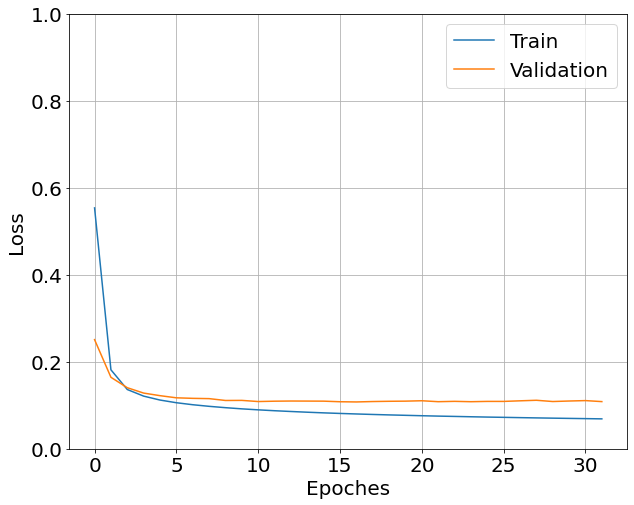

0.08324980381117968


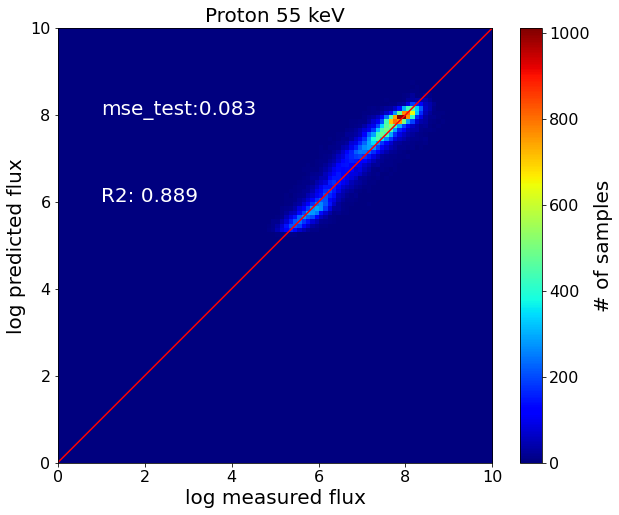

In [24]:

np.random.seed(41)
tf.random.set_seed(41)

n_neurons=10
dropout_rate=0.0
patience=15
lr=1e-3
epochs=40
batch_size=32 #default value
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience)
model = keras.models.Sequential([
    keras.layers.Dense(n_neurons, activation="relu", input_shape=X_train.shape[1:]),
    #keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(n_neurons, activation="relu", input_shape=(n_neurons+1,0)),
    keras.layers.Dense(n_neurons, activation="relu", input_shape=(n_neurons+1,0)),
    keras.layers.Dense(n_neurons, activation="relu", input_shape=(n_neurons+1,0)),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=lr))#tf.optimizers.Adam(learning_rate=lr))# 
history = model.fit(X_train, y_train, epochs=epochs,
     #batch_size=batch_size,\ #Default batch_size=32
     validation_data=(X_valid, y_valid),callbacks=[callback])


dir_out=dir0+'/lws_results/rbspice/p_'+str(df_flux.columns[iek+1])+'_keV/Lshell/'
os.makedirs(dir_out, exist_ok = True) 
str_now=datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
fn1=str(n_neurons)+'_neurons_'+str(len(model.layers))+'_layers_'+str(dropout_rate)+'_dropout_'+str(patience)+'_patience_'
fn1=fn1+str(lr)+'_lr_'+str(epochs)+'_epochs_'+str(batch_size)+'_batchsize_'+str_now
model.save(dir_out+'model_'+fn1+'.h5')
#model_1 = keras.models.load_model("March23.h5")

y_test_reshaped=y_test.reshape([-1])
y_test_pred = model.predict(X_test)
y_test_pred_reshaped=y_test_pred.reshape([-1])
corr = r2_score(y_test_reshaped, y_test_pred_reshaped)
lws_rbspice_loss_function_history(figname=dir_out+'mse_'+fn1) 
lws_rbspice_correlation(figname=dir_out+'corr_'+fn1)

In [ ]:
# Test which parameter is most important

np.random.seed(41)
tf.random.set_seed(41)

n_neurons=15
dropout_rate=0.0
patience=15
lr=1e-3
epochs=40
batch_size=32 #default value
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience)

for kk in np.arange(-1,M_symh):
    ind_XX1 = np.arange(kk,N_ftr,M_symh) 
    ind_XX2 = np.arange(N_ftr,N_X) #coordinates
    if (kk>=0):
        ind_X = np.concatenate((ind_XX1,ind_XX2))
    else:
        ind_X = ind_XX2 # Coordinates only


    model = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="relu", input_shape=X_train[:,ind_X].shape[1:]),
        keras.layers.Dense(n_neurons, activation="relu", input_shape=(n_neurons+1,0)),
        #keras.layers.Dense(n_neurons, activation="relu", input_shape=(n_neurons+1,0)),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=lr))
    history = model.fit(X_train[:,ind_X], y_train, epochs=epochs, validation_data=(X_valid[:,ind_X], y_valid),callbacks=[callback])
    #model.save("March23.h5")
    #model_1 = keras.models.load_model("March23.h5")

    dir_out=dir0+'/lws_results/rbspice/p_'+str(df_flux.columns[iek+1])+'_keV/Lshell/'
    os.makedirs(dir_out, exist_ok = True) 
    str_now=datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    fn1=str(n_neurons)+'_neurons_'+str(len(model.layers))+'_layers_'+str(dropout_rate)+'_dropout_'+str(patience)+'_patience_'
    fn1=fn1+str(lr)+'_lr_'+str(epochs)+'_epochs_'+str(batch_size)+'_batchsize_'+str_now+ '_'+df_symh.columns[kk+1]
    model.save(dir_out+'model_'+fn1+'.h5')
    #model_1 = keras.models.load_model("March23.h5")

    y_test_reshaped=y_test.reshape([-1])
    y_test_pred = model.predict(X_test[:,ind_X])
    y_test_pred_reshaped=y_test_pred.reshape([-1])
    corr = r2_score(y_test_reshaped, y_test_pred_reshaped)
    lws_rbspice_loss_function_history(figname=dir_out+'mse_'+fn1) 
    lws_rbspice_correlation(figname=dir_out+'corr_'+fn1)


In [ ]:
# Test Optimal history length for specific feature parameter

np.random.seed(41)
tf.random.set_seed(41)

n_neurons=15
dropout_rate=0.0
patience=15
lr=2e-3
epochs=40
batch_size=32 #default value
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience)

kk=5
# Modified on May 19, 2022
k_feature = 1
if (kk==1):
    ind_XX1= np.arange((10-0)*12*M_symh+k_feature,N_ftr,M_symh)
else:
    ind_XX1= np.arange((10-kk)*12*M_symh+k_feature,N_ftr,M_symh)

ind_XX2 = np.arange(N_ftr,N_X) #coordinates
if (kk>0):
    ind_X = np.concatenate((ind_XX1,ind_XX2))
else:
    ind_X = ind_XX2 # Coordinates only
#ind_X= np.arange((10-kk)*12*M_symh+k_feature,N_X,M_symh)

model = keras.models.Sequential([
    keras.layers.Dense(n_neurons, activation="relu", input_shape=X_train[:,ind_X].shape[1:]),
    keras.layers.Dense(n_neurons, activation="relu", input_shape=(n_neurons+1,0)),
    #keras.layers.Dense(n_neurons, activation="relu", input_shape=(n_neurons+1,0)),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=lr))
history = model.fit(X_train[:,ind_X], y_train, epochs=epochs, validation_data=(X_valid[:,ind_X], y_valid),callbacks=[callback])
#model.save("March23.h5")
#model_1 = keras.models.load_model("March23.h5")

dir_out=dir0+'/lws_results/rbspice/p_'+str(df_flux.columns[iek+1])+'_keV/history/'
os.makedirs(dir_out, exist_ok = True) 
str_now=datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
fn1=str(n_neurons)+'_neurons_'+str(len(model.layers))+'_layers_'+str(dropout_rate)+'_dropout_'+str(patience)+'_patience_'
fn1=fn1+str(lr)+'_lr_'+str(epochs)+'_epochs_'+str(batch_size)+'_batchsize_'+str_now+ '_'+str(kk)+'_days'
model.save(dir_out+'model_'+fn1+'.h5')
#model_1 = keras.models.load_model("March23.h5")

y_test_reshaped=y_test.reshape([-1])
y_test_pred = model.predict(X_test[:,ind_X])
y_test_pred_reshaped=y_test_pred.reshape([-1])
corr = r2_score(y_test_reshaped, y_test_pred_reshaped)
lws_rbspice_loss_function_history(figname=dir_out+'mse_'+fn1) 
lws_rbspice_correlation(figname=dir_out+'corr_'+fn1)


In [ ]:
# Test Optimal history length for all feature parameter

np.random.seed(41)
tf.random.set_seed(41)

n_neurons=10
dropout_rate=0.0
patience=15
lr=2e-3
epochs=40
batch_size=32 #default value
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience)

for kk in np.arange(10,9,-1):
    if (kk==0):
        ind_X= np.arange(N_ftr,N_X) #coordinates
    else:
        if (kk==1):
            ind_X= np.arange((10-0)*12*M_symh,N_X)
        else:
            ind_X= np.arange((10-kk)*12*M_symh,N_X)
    

    #ind_X= np.arange((10-kk)*12*M_symh+k_feature,N_X,M_symh)

    model = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="relu"),
        keras.layers.Dense(n_neurons, activation="relu"),
        keras.layers.Dense(n_neurons, activation="relu"),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=lr))
    history = model.fit(X_train[:,ind_X], y_train, epochs=epochs, validation_data=(X_valid[:,ind_X], y_valid),callbacks=[callback])
    #model.save("March23.h5")
    #model_1 = keras.models.load_model("March23.h5")

    dir_out=dir0+'/lws_results/rbspice/p_'+str(df_flux.columns[iek+1])+'_keV/history_2_layers/'
    os.makedirs(dir_out, exist_ok = True) 
    str_now=datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    fn1=str(n_neurons)+'_neurons_'+str(len(model.layers))+'_layers_'+str(dropout_rate)+'_dropout_'+str(patience)+'_patience_'
    fn1=fn1+str(lr)+'_lr_'+str(epochs)+'_epochs_'+str(batch_size)+'_batchsize_'+str_now+ '_'+str(kk)+'_days'
    model.save(dir_out+'model_'+fn1+'.h5')
    #model_1 = keras.models.load_model("March23.h5")

    y_test_reshaped=y_test.reshape([-1])
    y_test_pred = model.predict(X_test[:,ind_X])
    y_test_pred_reshaped=y_test_pred.reshape([-1])
    corr = r2_score(y_test_reshaped, y_test_pred_reshaped)
    lws_rbspice_loss_function_history(figname=dir_out+'mse_'+fn1) 
    lws_rbspice_correlation(figname=dir_out+'corr_'+fn1)


In [ ]:
## The following sections are to visulize the long-term variation of modeled proton flux
tstr_plot_begin='2017-01-01 00:00:00'
tstr_plot_end='2017-07-01 00:00:00'
class time_series():
    x = []
    y = []
    v = []
    ylabel = 'y'
    xlabel = 'x'
    linecolors = 'k'
    plot_style = 'plt'
    title= 'title'
    vrange=[]
    cmap='jet'

indt1_symh=np.where(df_symh['Datetime'] >= tstr_plot_begin)
indt1_symh=indt1_symh[0][0]
indt2_symh=np.where(df_symh['Datetime'] <= tstr_plot_end)
indt2_symh=indt2_symh[0][-1]+1
tarr_dt=df_symh['Datetime'].astype('datetime64')[indt1_symh:indt2_symh].reset_index(drop=True)

indt1_flux=np.where(df_flux['Datetime'][0:N_sample_per_probe] >= tstr_plot_begin)
indt1_flux=indt1_flux[0][0]
indt2_flux=np.where(df_flux['Datetime'][0:N_sample_per_probe] <= tstr_plot_end)
indt2_flux=indt2_flux[0][-1]+1

t_symh = time_series()
t_symh.x = tarr_dt
t_symh.y = df_symh['SymH'][indt1_symh:indt2_symh].reset_index(drop=True)
t_symh.ylabel = 'SymH (nT)'

t_asyh = time_series()
t_asyh.x = tarr_dt
t_asyh.y = df_symh['AsyH'][indt1_symh:indt2_symh].reset_index(drop=True)
t_asyh.ylabel = 'AsyH (nT)'

t_asyd = time_series()
t_asyd.x = tarr_dt
t_asyd.y = df_symh['AsyD'][indt1_symh:indt2_symh].reset_index(drop=True)
t_asyd.ylabel = 'AsyD (nT)'


t_sme = time_series()
t_sme.x = tarr_dt
t_sme.y = df_symh['SME'][indt1_symh:indt2_symh].reset_index(drop=True)
t_sme.ylabel = 'SME (nT)'


t_sml = time_series()
t_sml.x = tarr_dt
t_sml.y = df_symh['SML'][indt1_symh:indt2_symh].reset_index(drop=True)
t_sml.ylabel = 'SML (nT)'


t_vx= time_series()
t_vx.x = tarr_dt
t_vx.y = df_symh['Vx'][indt1_symh:indt2_symh].reset_index(drop=True)
t_vx.ylabel = 'Vx km/s'

t_density = time_series()
t_density.x = tarr_dt
t_density.y = df_symh['Density'][indt1_symh:indt2_symh].reset_index(drop=True)
t_density.ylabel='Density'

t_pflux = time_series()
t_pflux.x = tarr_dt
t_pflux.y = df_coord['L'][indt1_flux:indt2_flux].reset_index(drop=True)
t_pflux.v = df_flux.iloc[:,iek+1][indt1_flux:indt2_flux].reset_index(drop=True)
t_pflux.ylabel = 'L'
t_pflux.plot_style = 'scatter'  # 'colorline'
t_pflux.vrange = [4, 9]

t_flux=[]
for i in range(df_flux.columns.shape[0]):
    t_flux1 = time_series()
    t_flux1.x = tarr_dt
    t_flux1.y = df_coord['L'][indt1_flux:indt2_flux].reset_index(drop=True)
    t_flux1.v = df_flux.iloc[:,(i+1):(i+2)][indt1_flux:indt2_flux].reset_index(drop=True)
    t_flux1.ylabel = 'L'
    t_flux1.plot_style = 'scatter'  # 'colorline'
    t_flux1.vrange = [4, 9]

    t_flux.append(t_flux1)
    del t_flux1

In [ ]:
t_flux=[]
for i in range(df_flux.columns.shape[0]):
    t_flux1 = time_series()
    t_flux1.x = tarr_dt
    t_flux1.y = df_coord['L'][indt1_flux:indt2_flux].reset_index(drop=True)
    t_flux1.v = df_flux.iloc[:,(i+1):(i+2)][indt1_flux:indt2_flux].reset_index(drop=True)
    t_flux1.ylabel = 'L'
    t_flux1.plot_style = 'scatter'  # 'colorline'
    t_flux1.vrange = [4, 9]

    t_flux.append(t_flux1)
    del t_flux1

In [ ]:
indt1_test=np.where((df_coord['Datetime'][ind_test] >= tstr_plot_begin) & (ind_test < df_coord.shape[0]/2)) 
# probe A: ind_test < df_coord.shape[0]/2; Probe B: # probe A: ind_test >= df_coord.shape[0]/2
indt2_test=np.where((df_coord['Datetime'][ind_test] <= tstr_plot_end  ) & (ind_test < df_coord.shape[0]/2))
indt1_test=indt1_test[0][0]
indt2_test=indt2_test[0][-1]
ind_test_plot=ind_test[indt1_test:indt2_test]
tarr_test=df_coord['Datetime'].astype('datetime64')[ind_test_plot]#.reset_index(drop=True)

t_y_test = time_series()
t_y_test.x = tarr_test
t_y_test.y = df_coord['L'][ind_test_plot]
t_y_test.v = df_flux.iloc[:,iek+1][ind_test_plot]#.reset_index(drop=True)
t_y_test.ylabel = 'L'
t_y_test.plot_style = 'scatter' #'colorline'
t_y_test.vrange=[4,9]
t_y_test.title='Data'
t_y_test.cmap='jet'

t_y_pred = time_series()
t_y_pred.x = tarr_test
t_y_pred.y = df_coord['L'][ind_test_plot]
t_y_pred.v =  y_test_pred_reshaped[0:ind_test_plot.size]
t_y_pred.ylabel = 'L'
t_y_pred.plot_style = 'scatter' #'colorline'
t_y_pred.vrange=[4,9]
t_y_pred.title='Prediction'
t_y_pred.cmap='jet'

t_y_diff = time_series()
t_y_diff.x = tarr_test
t_y_diff.y = df_coord['L'][ind_test_plot]
t_y_diff.v =  y_test_pred_reshaped[0:ind_test_plot.size]-df_flux.iloc[:,iek+1][ind_test_plot].reset_index(drop=True)
t_y_diff.ylabel = 'L'
t_y_diff.plot_style = 'scatter' #'colorline'
t_y_diff.vrange=[-2,2]
t_y_diff.title='Prediction - Data'
t_y_diff.cmap='bwr'

In [ ]:
t_y_test.vrange=[4,9]
t_y_pred.vrange=[4,9]

In [ ]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
fig5=plt.figure(figsize=(18, 14),facecolor='white')   

obj_arr = [t_sme,t_symh,t_asyh,t_asyd,t_y_test,t_y_pred,t_y_diff]
obj_arr = [t_flux[1]]
#obj_arr = [t_sme,t_symh,t_pflux,t_y_test,t_y_pred,t_y_diff]
n_subfig= len(obj_arr)

ax_x0=0.2
ax_y0=0.2
ax_xw=0.7
ax_yw=0.7
ax_dy_gap=0.01
ax_dy1=(ax_yw+ax_dy_gap) / n_subfig 
ax_dy0=ax_dy1-ax_dy_gap
fs_label=14

fig5, axs = plt.subplots(n_subfig,1, constrained_layout=True)
fig5.set_size_inches(15, 10.5)

for k in range(n_subfig):
    #axs[k].set_position([ax_x0,ax_y0+(n_subfig-k)*ax_dy1,ax_xw,ax_dy0])
    obj0=obj_arr[k]

    if obj0.plot_style == 'plt':
        s1=axs[k].plot(obj0.x,obj0.y,c=obj0.linecolors)
    elif obj0.plot_style == 'scatter':
        #c = cm.jet((obj0.v-cmin)/(cmax-cmin))

        #cmap = plt.cm.get_cmap("jet")
        #cmap='bwr'
        if not obj0.vrange:
            s1=axs[k].scatter(obj0.x,obj0.y,c=obj0.v, cmap=obj0.cmap,alpha=0.9)
        else:
            s1=axs[k].scatter(obj0.x,obj0.y,c=obj0.v, cmap=obj0.cmap,alpha=0.9,vmin=obj0.vrange[0],vmax=obj0.vrange[1])
        axs[k].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        #axs[k].text(obj0.x[1],min(obj0.y)+0.8*(max(obj0.y)-min(obj0.y)),obj0.title,fontsize=fs_label)
        fig5.colorbar(s1, ax=axs[k],fraction=0.02,pad=0.01)
        
    #y_min, y_max = axe[k]. get_ylim()
    axs[k].set_ylabel(obj0.ylabel,fontsize=fs_label)
    
    if k !=n_subfig-1:
        axs[k].tick_params(axis='x',labelbottom=False) # labels along the bottom edge are off
    else:
        axs[k].tick_params(axis='x',labelbottom=True) # labels along the bottom edge are on
    
    
    n_ts=obj0.x.shape[0]
    delta_t_days=obj0.x.reset_index(drop=True)[n_ts-1]-obj0.x.reset_index(drop=True)[0]
    
    #axs[k].set_xlim(pd.Timestamp('2017-05-20'),pd.Timestamp('2017-06-30'))
    
    if ( delta_t_days < dt.timedelta(days=30) ):
        axs[k].xaxis.set_major_locator(mdates.DayLocator())
        axs[k].xaxis.set_minor_locator(mdates.HourLocator())
        axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    else:
        axs[k].xaxis.set_major_locator(mdates.MonthLocator())
        axs[k].xaxis.set_minor_locator(mdates.DayLocator())
        axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axs[k].tick_params(axis='both', which='major', labelsize=16)
    axs[k].tick_params(axis='both', which='minor', labelsize=12)
    
axs[k].set_xlabel('Date',fontsize=fs_label)
figname=dir_out+'long_term_'+fn1
fig5.savefig(figname+"_6.pdf",format='pdf')
fig5.savefig(figname+"_6.png", format="png", dpi=300)

plt.show()